In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# Load the dataset
electricity = pd.read_csv('C:/Users/Ajay/Downloads/Machine learning capstone project/Capstone project 3/Electricity Consumption.csv')

In [3]:
# Ispecting the dataset
electricity.head()

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107


In [4]:
electricity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DATE                          561 non-null    object 
 1   Electricty_Consumption_in_TW  561 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


In [5]:
# Since date column is object type. Changing it to datetime type
electricity.DATE = pd.to_datetime(electricity.DATE)

In [6]:
# Now setting Date column as index
electricity.set_index('DATE', inplace=True)

In [7]:
# Now checking for any missing value
electricity.isna().sum()

Electricty_Consumption_in_TW    0
dtype: int64

Which means there are no missing values in the data

# Exploratory Data Analysis

# 1. Plotting the Time Series
To visualize the time series data to identify seasonlity, trends and any anomalies

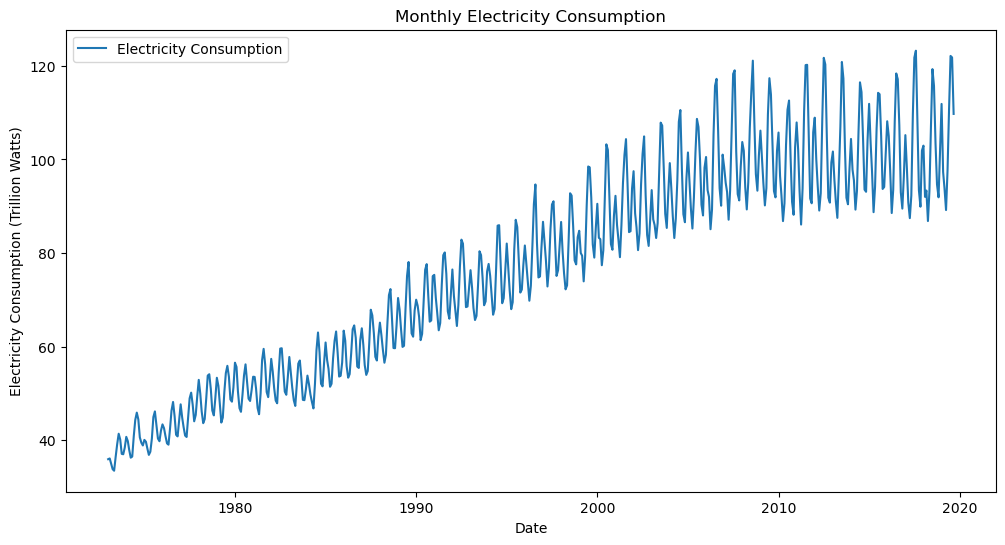

In [8]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(electricity.index, electricity['Electricty_Consumption_in_TW'], label='Electricity Consumption')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (Trillion Watts)')
plt.title('Monthly Electricity Consumption')
plt.legend()
plt.show()


# 2. Decompose the time series
To decompose the time series to visualize its trend, seasonality, and residual components.

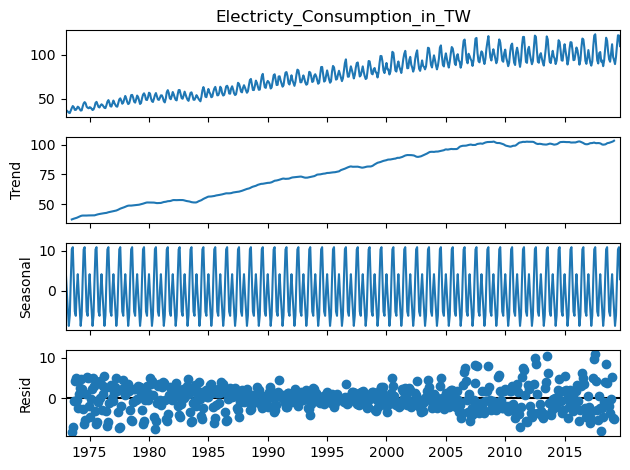

In [9]:
# Decompose the time series
decomposition = seasonal_decompose(electricity['Electricty_Consumption_in_TW'], model='additive')
decomposition.plot()
plt.show()


# Model Selection and Forecasting

A. Train and Test split of Dataset

In [10]:
# Define the split point
train = electricity[:'2017-09-01']
test = electricity['2017-10-01':]


B. ETS Models

In [11]:
# Train the ETS model
ets_model = ExponentialSmoothing(train['Electricty_Consumption_in_TW'], trend='add', seasonal='add', seasonal_periods=12)
ets_fit = ets_model.fit()

# Forecast the next 24 months
ets_forecast = ets_fit.forecast(steps=24)

C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


C. ARIMA/SARIMA Models

In [12]:
# Train the SARIMA model
sarima_model = SARIMAX(train['Electricty_Consumption_in_TW'], 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()

# Forecast the next 24 months
sarima_forecast = sarima_fit.get_forecast(steps=24)
sarima_forecast_conf_int = sarima_forecast.conf_int()


C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Ajay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


D. Model Evaluation

In [13]:
def calculate_metrics(actual, forecast):
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    rmspe = np.sqrt(np.mean(((actual - forecast) / actual) ** 2)) * 100
    return rmse, mape, rmspe

# Forecasted values from ETS and SARIMA models
ets_rmse, ets_mape, ets_rmspe = calculate_metrics(test['Electricty_Consumption_in_TW'], ets_forecast)
sarima_rmse, sarima_mape, sarima_rmspe = calculate_metrics(test['Electricty_Consumption_in_TW'], sarima_forecast.predicted_mean)

# Comparing model and selecting the best one for future forecast

In [14]:
print(f"ETS RMSE: {ets_rmse}, MAPE: {ets_mape}, RMSPE: {ets_rmspe}")
print(f"SARIMA RMSE: {sarima_rmse}, MAPE: {sarima_mape}, RMSPE: {sarima_rmspe}")

# Choose the best model based on error metrics
if ets_rmse < sarima_rmse:
    print("ETS model is selected based on RMSE.")
else:
    print("SARIMA model is selected based on RMSE.")


ETS RMSE: 5.7678104556604195, MAPE: 5.1527359614613495, RMSPE: 5.9060849115358875
SARIMA RMSE: 3.1074290145398593, MAPE: 2.4184506820110845, RMSPE: 3.1709955259644254
SARIMA model is selected based on RMSE.


# Forecasting Future Demand

In [15]:
# Use the selected model for forecasting (assuming SARIMA is selected)
future_forecast = sarima_fit.get_forecast(steps=24)
forecast_values = future_forecast.predicted_mean
forecast_index = pd.date_range(start=train.index.max() + pd.DateOffset(months=1),periods=24, freq='MS')

# Create a DataFrame for future forecast
forecast_df = pd.DataFrame(data=forecast_values, index=forecast_index)

In [18]:
forecast_df.rename(columns={'predicted_mean':'Forecast'}, inplace=True)

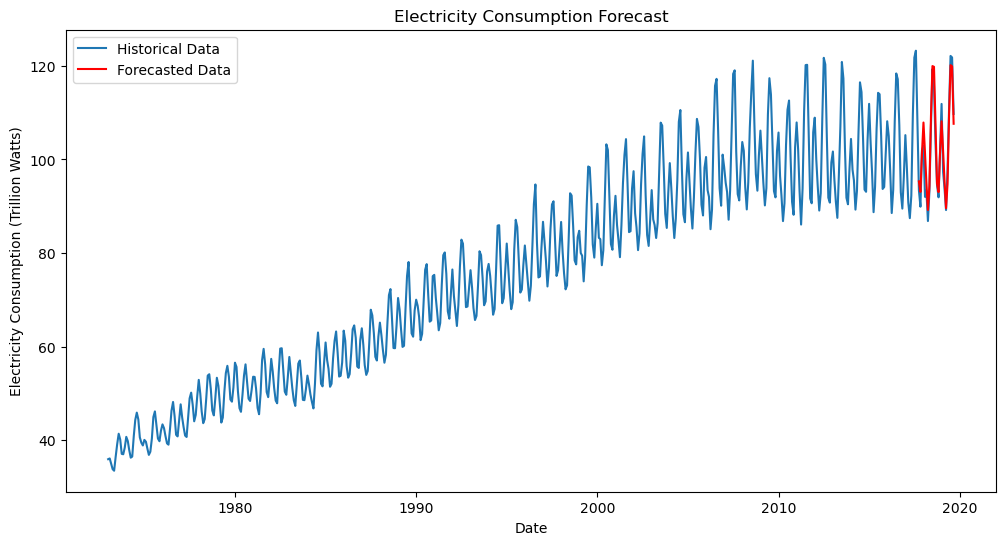

In [17]:
# Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(electricity.index, electricity['Electricty_Consumption_in_TW'], label='Historical Data')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecasted Data', color='red')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (Trillion Watts)')
plt.title('Electricity Consumption Forecast')
plt.legend()
plt.show()

# Thank You!